<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [189]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time

In [ ]:
# first look at structure of a webpage
URL = 'https://www.indeed.com/jobs?q=data+scientist&l=New+York'

# second page
# https://www.indeed.com/jobs?q=data+scientist&l=New+York&start=10

#conducting a request of the stated URL above:
page = requests.get(URL)

#specifying a desired format of “page” using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
soup = BeautifulSoup(page.text, 'html.parser')

#printing soup in a more structured tree format that makes for easier reading
print(soup.prettify())

In [ ]:
# look at a specific ad

URL = 'https://www.indeed.com/jobs?q=data%20scientist&l=New%20York&start=10&advn=3070326595930836&vjk=a7437f06fe22a0c5'

#conducting a request of the stated URL above:
page = requests.get(URL)

#specifying a desired format of “page” using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
soup = BeautifulSoup(page.text, 'html.parser')

#printing soup in a more structured tree format that makes for easier reading
print(soup.prettify())

In [202]:
from selenium import webdriver
import pandas as pd
from bs4 import BeautifulSoup

## Download the chromedriver from link in description
## And give the location of executable here
driver = webdriver.Chrome("./chromedriver")

dataframe = pd.DataFrame(columns=["Title","Location","Company","Salary","Sponsored","Description"])


for i in range(0,10,10):

    ##Step1: Get the page
	driver.get("https://www.indeed.com/jobs?q=data+scientist&l=New+York&start="+str(i))
	driver.implicitly_wait(4)

    # find all the divs with the results class in it 
	all_jobs = driver.find_elements_by_class_name('result')

	for job in all_jobs:

		result_html = job.get_attribute('innerHTML')
		soup = BeautifulSoup(result_html,'html.parser')

		try:
			title = soup.find("a",class_="jobtitle").text.replace('\n','')
		except:
			title = 'None'

		try:
			location = soup.find(class_="location").text
		except:
			location = 'None'

		try:
			company = soup.find(class_="company").text.replace("\n","").strip()
		except:
			company = 'None'

		try:
			salary = soup.find(class_="salary").text.replace("\n","").strip()
		except:
			salary = 'None'

		try:
			sponsored = soup.find(class_="sponsoredGray").text
			sponsored = "Sponsored"
		except:
			sponsored = "Organic"

		
		sum_div = job.find_elements_by_class_name("summary")[0]
		
		sum_div.click()
		# except:
		#	close_button = driver.find_elements_by_class_name("popover-x-button-close")[0]
		#	close_button.click()
		#	sum_div.click()
			

		vjs = driver.find_element_by_id('vjs-desc')
		job_desc = vjs.text


		dataframe = dataframe.append({'Title':title,'Location':location,"Company":company,
						"Sponsored":sponsored,"Description":job_desc},
						ignore_index=True)


dataframe.to_csv("datascience.csv",index=False)

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="vjs-desc"]"}
  (Session info: chrome=77.0.3865.90)


In [195]:
df = pd.read_csv('./datascience.csv')
df.head()

,Title,Location,Company,Salary,Sponsored,Description
0,Data Scientist,"New York, NY 10261",Qualia Investments,NaN,Sponsored,NaN
1,Data Scientist,"New York, NY",Seen by Indeed,NaN,Sponsored,NaN
2,Data Scientist,"Buffalo, NY 14202 (Central Business District a...",Campus Labs,NaN,Sponsored,NaN
3,Data Scientist - Experimentation,"New York, NY",Disney Streaming Services,NaN,Sponsored,NaN
4,Data Science Engineer,"New York, NY",Eskalera Inc.,NaN,Sponsored,NaN


In [ ]:
URL = 'https://www.indeed.com/jobs?q=data+scientist&l=New+York'

#conducting a request of the stated URL above:
page = requests.get(URL)

#specifying a desired format of “page” using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
soup = BeautifulSoup(page.text, 'html.parser')

#printing soup in a more structured tree format that makes for easier reading
print(soup.prettify())

In [144]:
# get job title

def extract_job_title_from_result(soup): 
  jobs = []
  for div in soup.find_all('div', attrs={'class':'row'}):
    for a in div.find_all('a', attrs={'data-tn-element':'jobTitle'}):
        jobs.append(a['title'])
  return(jobs)

title = extract_job_title_from_result(soup)

In [145]:
# get job description

def extract_summary_from_result(soup): 
    summaries = []
    spans = soup.find_all('div', attrs={'class': 'summary'})
    for span in spans:
        summaries.append(span.text.strip())
    return(summaries)

summary = extract_summary_from_result(soup)

In [147]:
df = pd.DataFrame(list(zip(title, summary)), columns=['title', 'summary'])
df.head()

,title,summary
0,Enterprise Data - Quant Researcher (Machine Le...,Enterprise Data Quant Researcher to will apply...
1,Data Science Engineer,"In your past, you may have doubled as a data s..."
2,Data Science Full-Time Student Opportunity (Gr...,We’re focused on creating new opportunities th...
3,Data Scientist,The Health Data Scientist is the team steward ...
4,Data Science Full-Time Student Opportunity (Un...,We’re focused on creating new opportunities th...


In [89]:
max_results = 20
#columns = ['title', 'summary']
df = df.iloc[0:0]
df = pd.DataFrame()

In [90]:
for start in range(0, max_results, 10):
    page = requests.get('https://www.indeed.com/jobs?q=data+scientist&l=New+York' + '&start' + str(start))
    
    # delay by x seconds
    time.sleep(1)
    
    soup = BeautifulSoup(page.content, 'html.parser', from_encoding="utf-8")
    for each in soup.find_all(class_= "result"): 
        
        # grabbing job title
        for div in soup.find_all('div', attrs={'class':'row'}): 
            for a in div.find_all('a', attrs={'data-tn-element':'jobTitle'}):
                # print(a)
                title = a['title']

        # grabbing summary
        # spans = soup.find_all('div', attrs={'class': 'summary'})
        # print(spans)
        # for span in spans:
            # summary = span.text.strip()
        summary = each.find('span', {'class':'summary'})
        
        df = df.append({'title': title, 'summary': summary}, ignore_index=True)

df.head(10)

,summary,title
0,None,Data Scientist - Modeling
1,None,Data Scientist - Modeling
2,None,Data Scientist - Modeling
3,None,Data Scientist - Modeling
4,None,Data Scientist - Modeling
5,None,Data Scientist - Modeling
6,None,Data Scientist - Modeling
7,None,Data Scientist - Modeling
8,None,Data Scientist - Modeling
9,None,Data Scientist - Modeling


In [ ]:
max_results = 20
# columns = ['title', 'summary']
df = df.iloc[0:0]
df = pd.DataFrame()

for start in range(0, max_results, 10):
    page = requests.get('https://www.indeed.com/jobs?q=data+scientist&l=New+York' + '&start' + str(start))
    
    # delay by x seconds
    time.sleep(1)
    
    soup = BeautifulSoup(page.content, 'html.parser', from_encoding="utf-8")

for div in soup.find_all('div', attrs={'class':'row'}): 

    # grabbing job title
    for a in div.find_all('a', attrs={'data-tn-element':'jobTitle'}):
        # print(a)
        title = a['title']

    # grabbing summary
    spans = soup.find_all('div', attrs={'class': 'summary'})
    print(spans)
    for span in spans:
        summary = span.text.strip()
        
    df = df.append({'title': title, 'summary': summary}, ignore_index=True)

df.head(20)

In [ ]:
def extract_summary_from_result(soup): 
    summaries = []
    spans = soup.find_all('div', attrs={'class': 'summary'})
    for span in spans:
        summaries.append(span.text.strip())
    return(summaries)

def extract_job_title_from_result(soup): 
  jobs = []
  for div in soup.find_all('div', attrs={'class':'row'}):
    for a in div.find_all('a', attrs={'data-tn-element':'jobTitle'}):
        jobs.append(a['title'])
  return(jobs)
extract_job_title_from_result(soup)

In [127]:
from bs4 import BeautifulSoup

data['description'] = data['description'].apply(lambda x: BeautifulSoup(x).get_text()[2:].replace('\\n', ' '))
data['description'] = data['description'].str.replace(r'\\(x|n)[a-z0-9]{0,2}', '')

In [128]:
data.head()

,Unnamed: 0,description,title
0,0,b Requirements: Conceptual understanding in Ma...,Data scientist
1,1,"b Description As a Data Scientist 1, you will...",Data Scientist I
2,2,a Data Scientist you will be working on consu...,Data Scientist - Entry Level
3,3,",969 - $6,756 a monthContractUnder the general...",Data Scientist
4,4,cation: USA multiple locations 2+ years of An...,Data Scientist


## 2) Use Spacy to tokenize / clean the listings 

In [149]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [164]:
def get_lemmas(text):
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['tokens'] = df['summary'].apply(get_lemmas)

In [165]:
df['tokens']

0     [enterprise, data, quant, researcher, apply, c...
1     [in, past, double, data, scientist, data, engi...
2     [be, focus, create, new, opportunity, drive, c...
3     [the, health, data, scientist, team, steward, ...
4     [be, focus, create, new, opportunity, drive, c...
5     [use, r, ad, hoc, modeling, analysis, strong, ...
6     [look, scientist, tech, industry, experience, ...
7     [familiarity, technical, tool, analysis, pytho...
8     [build, team, junior, data, scientist, work, s...
9     [100, coverage, health, vision, dental, insura...
10    [able, present, information, audience, effecti...
11    [knowledge, algorithm, datum, mining, machine,...
12    [nike, 's, member, data, science, grow, organi...
13    [in, role, lead, effort, machine, learning, pr...
14    [the, creator, product, insights, team, thrivi...
15    [academic, industry, example, machine, learnin...
16    [expertise, programming, language, datum, proc...
17    [deep, knowledge, machine, learn, algorith

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [166]:
from sklearn.feature_extraction.text import CountVectorizer

data = df['summary']

# instantiate count
vect = CountVectorizer(stop_words='english', min_df = 0.05, max_df= 0.90)

# tokenize and build vocab
vect.fit(data)

# transform text
sparse_dtm = vect.transform(data)

dtm = pd.DataFrame(sparse_dtm.todense(), columns=vect.get_feature_names())

In [167]:
dtm.head()

,100,20,able,academic,access,ad,advanced,advise,algorithms,analysis,...,unsupervised,use,user,varied,various,view,vision,visualizations,work,working
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [168]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [171]:
wc = count(df['tokens'])

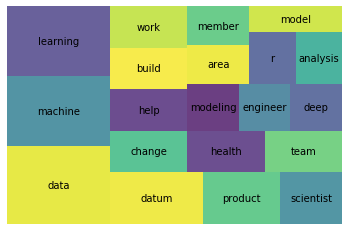

In [173]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words = 'english')

# Create a vocabulary and get word counts per document
sparse = tfidf.fit_transform(data)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,100,20,able,academic,access,ad,advanced,advise,algorithms,analysis,...,unsupervised,use,user,varied,various,view,vision,visualizations,work,working
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.275614,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.294118,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [177]:
# Instantiate
from sklearn.neighbors import NearestNeighbors


# Fit on TF-IDF Vectors
nn  = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [179]:
# Query Using kneighbors 
nn.kneighbors([dtm.iloc[0]])

(array([[0.        , 1.32925929, 1.33137083, 1.35699672, 1.35808479]]),
 array([[ 0,  6, 11,  1, 15]]))

In [180]:
ideal_job = ["""Requirements - Recent graduates or final year students. - Should desirably have knowledge of modeling techniques (logit, GLM, time series, decision trees, random forests, clustering), statistical programming languages (SAS, R, Python, Matlab) and big data tools and platforms (Hadoop, Hive, etc.). - Solid academic record. - Strong computer skills. - Postgraduate studies and/or specialised courses are an asset, especially in Data Science, Quantitative Finance or similar. - Knowledge of other languages is desirable. - Get-up-and-go attitude, maturity, responsibility and strong work ethic. - Strong ability to learn quickly. - Able to integrate easily into multidisciplinary teams.
"""]

In [182]:
# Query for Sim of Random doc to BBC
new = tfidf.transform(ideal_job)

nn.kneighbors(new.todense())

(array([[1.12091916, 1.16416807, 1.25646688, 1.3203965 , 1.33720868]]),
 array([[16,  5, 17, 15,  6]]))

In [183]:
# inspect most relevant result
data[16]

'Expertise in programming languages for data processing and analysis (e.g., Python and R) and big data access tools.'

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 